# Классификатор эмоций

В этом нойтбуке создается и обучается модель для классификации эмоций по изображению лица

In [1]:
import tensorflow as tf 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input, decode_predictions as resnet50_decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input, decode_predictions as vgg16_decode_predictions 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input, decode_predictions as xception_decode_predictions 


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from pathlib import Path

import random
import datetime as dt 

## Опредление путей к данным

In [2]:
# флаг использования Google drive как хранилища данных
USE_GOOGLE_DRIVE = False

#Корневая папка проекта
root_dir = ''

In [3]:
#Подключаем google drive, если код будет выполняться в Colab
if USE_GOOGLE_DRIVE:
    from google.colab import drive

    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/Projects/EmoDetector'
    
    import sys
    sys.path.append(root_dir)
    
#if

In [4]:
import emo_utils as utils

In [5]:
#Получаем пути к директориям и файлам проекта

paths = utils.get_paths(root_dir)

print (paths)

{'data_dir': 'data', 'model_dir': 'model', 'train_data_dir': 'data/train', 'test_data_dir': 'data/test_kaggle', 'class_names_path': 'data/class_names.txt', 'best_checkpoint_path': 'model/emo_classificator_best'}


## Создание модели

In [21]:
# Гиперпараметры
BATCH_SIZE = 32
IMAGE_SIZE = 299
VALIDATION_SPLIT = 0.2
NUM_CLASSES = 9
EPOCHS = 10

#тип базовой модели
BASE_MODEL = 'xception'

#Флаг использования аугментации
USE_AUGMENTATION = True

In [22]:
def create_model (p_base_model, p_num_classes = 9):
    '''
    Создание модели для классификации эмоций по картинке
    
    :argument
    p_base_model - тип базовой модели:
     resnet50
     vgg16
     xception
         
    p_num_classes - количество определяемых классов
    
    return:
    base_model- базовая модель, предназначенная для извлечения признаков с картинки
    model - модель для классификации эмоций, построенная на базовой модели
    preprocessed_input - функция для обработки входных данных для базовой модели
    decode_predictions - функция для расшифровки предсказания базовой модели
    
    '''
    
    base_model = None
    model = None
    preprocess_input = None
    decode_predictions = None
    
    if p_base_model == 'resnet50':        
        
        base_model = ResNet50(weights='imagenet')
        #отрежем последние слои
        base_layers = tf.keras.Model([base_model.input], base_model.get_layer("avg_pool").output)
        
        #добавим новые слои для обучения и классификации
        model = tf.keras.Sequential([base_layers,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(1024, activation='relu'),
                                 tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        preprocess_input = resnet50_preprocess_input
        decode_predictions = resnet50_decode_predictions
        
    #if
    if p_base_model == 'vgg16':            
             
        base_model = VGG16(weights='imagenet')
        #отрежем последние слои
        base_layers = tf.keras.Model([base_model.input], base_model.get_layer('block5_pool').output)
        
        #добавим новые слои для обучения и классификации
        model = tf.keras.Sequential([base_layers,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(512, activation='relu'),
                                 tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        preprocess_input = vgg16_preprocess_input
        decode_predictions = vgg16_decode_predictions
        
    #if
    
    if p_base_model == 'xception':
        
             
        base_model = Xception(weights='imagenet')
        #отрежем последние слои
#        base_layers = tf.keras.Model([base_model.input], base_model.get_layer('avg_pool').output)
                
        base_layers = tf.keras.applications.Xception(weights="imagenet",
                                                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                                 include_top=False)
    
        #добавим новые слои для обучения и классификации
#        model = tf.keras.Sequential([base_layers,
#                                 tf.keras.layers.Flatten(),
#                                 tf.keras.layers.Dense(1024, activation='relu'),
#                                 tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        model = tf.keras.Sequential([base_layers,
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dropout(0.2),
                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        
        
        preprocess_input = xception_preprocess_input
        decode_predictions = xception_decode_predictions
        
    #if
    
    
    #"заморозим" базовые слои
    base_layers.trainable = False
      
    return base_model, model, preprocess_input, decode_predictions

#create_model

In [23]:
base_model, model_emo_classifier, preprocess_input, decode_predictions = create_model (p_base_model=BASE_MODEL)

model_emo_classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 18441     
Total params: 20,879,921
Trainable params: 18,441
Non-trainable params: 20,861,480
_________________________________________________________________


In [24]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [25]:
#model_emo_classifier.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                             loss= 'categorical_crossentropy',
#                             metrics= ['accuracy'])

model_emo_classifier.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                             loss= 'categorical_crossentropy',
                             metrics= ['accuracy'])

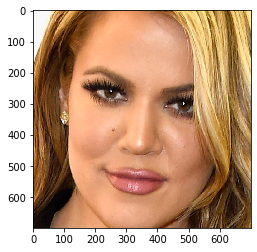

Predicted: [('n03676483', 'lipstick', 0.54737234), ('n04584207', 'wig', 0.1397457), ('n03404251', 'fur_coat', 0.04824299)]


In [26]:
#Проверим базовую модель

img_path = paths['test_data_dir'] + '/4999.jpg'

#Отобразим картинку
plt.imshow(mpimg.imread(img_path))
plt.show()

#!!!Вынести в отдельную функцию
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = base_model.predict(x)

#print(preds)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [27]:
# Создадим генератор картинок для обучения модели

if USE_AUGMENTATION:
    image_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   validation_split = VALIDATION_SPLIT,
                                   #Используем аугментацию для увеличения набора данных
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   height_shift_range=0.2,
                                   width_shift_range=0.2,
                                   rotation_range=15)
else:
    image_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   validation_split = VALIDATION_SPLIT)
    

train_generator = image_gen.flow_from_directory (directory= paths['train_data_dir'],
                                                 class_mode= 'categorical', 
                                                 batch_size = BATCH_SIZE, 
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 subset = 'training')

val_generator = image_gen.flow_from_directory (directory= paths['train_data_dir'],
                                               class_mode= 'categorical', 
                                               batch_size = BATCH_SIZE, 
                                               target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                               subset = 'validation',
                                               shuffle = False)


Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


In [28]:
# Сохраним список классов, чтобы можно было их в последствии декодировать

classes_names = ''
for key in train_generator.class_indices.keys():
    if classes_names == '': 
        classes_names = key
    else:
        classes_names = classes_names + ',' + key

with open(paths['class_names_path'], 'w') as output:
    output.write(classes_names)

In [29]:
#Создаем объект для сохранения модели во время обучения

checkpoint_path = paths['best_checkpoint_path'] \
                  +'_'+ dt.datetime.now().strftime ('%y%m%d%H%M%S') \
                  +'_'+ BASE_MODEL \
                  + '_e' + str(EPOCHS)+'.h5'

#Настраиваем объект для сохранения результатов работы модели
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor= 'val_accuracy',
                                                verbose= 1, 
                                                save_best_only= True, 
                                                mode='max')

In [26]:
# Обучение модели

history = model_emo_classifier.fit(train_generator,
                                   validation_data = val_generator,
                                   epochs = EPOCHS,
                                   #steps_per_epoch = 25,
                                   callbacks = [checkpoint])

Epoch 1/10
   7/1252 [..............................] - ETA: 1:17:56 - loss: 2.2407 - accuracy: 0.0893

KeyboardInterrupt: 

In [42]:
history.history

{'loss': [1.9753791093826294, 1.8881577253341675],
 'categorical_accuracy': [0.2748819887638092, 0.3077499568462372],
 'val_loss': [1.9406979084014893, 1.9128695726394653],
 'val_categorical_accuracy': [0.2929949164390564, 0.29869091510772705]}

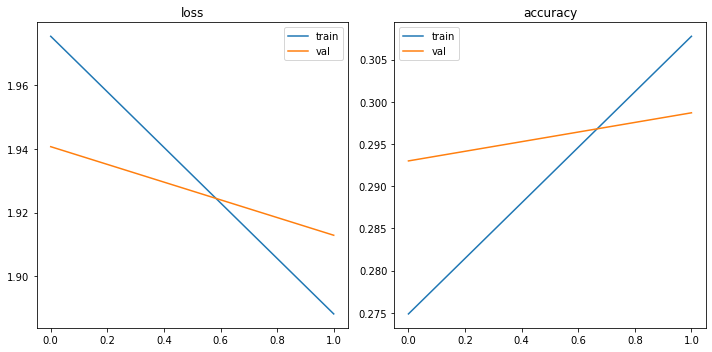

In [47]:
#Визуализируем данные обучения

fig = plt.figure(tight_layout=True)

#задаем размерность сетки для размещения графиков
gs= fig.add_gridspec(1,2)
fig.set_size_inches(10, 5)

ax = fig.add_subplot(gs[0,0])
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'val')
        
#Добавление подписей на график
ax.set_title('loss')
ax.legend()

ax = fig.add_subplot(gs[0,1])
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'val')

ax.set_title('accuracy')
ax.legend()

plt.savefig(checkpoint_path.replace('.h5', '.png'))
plt.show()

## Тест модели

In [27]:
# Загрузим модель
model = tf.keras.models.load_model(checkpoint_path)

#model.evaluate(val_generator)

In [28]:
#загрузим названия классов
classes_names = []
with open(paths['class_names_path'], 'r') as f:
    classes_names = f.read().split(',')

In [29]:
# выберем картинки для проверки
sample_cnt = 12

sample_img_paths = []
sample_img_labels = []
for i in range (sample_cnt):
    index = random.choice(range(0, len(val_generator.filepaths)))
    sample_img_paths.append (val_generator.filepaths[index])
    sample_img_labels.append (val_generator.labels[index])
    
#for

print (sample_img_paths)
print (sample_img_labels)

['data/train/surprise/2134.jpg', 'data/train/surprise/1021.jpg', 'data/train/happy/2005.jpg', 'data/train/anger/1041.jpg', 'data/train/disgust/1.jpg', 'data/train/anger/2085.jpg', 'data/train/anger/113.jpg', 'data/train/sad/1651.jpg', 'data/train/happy/1768.jpg', 'data/train/happy/1746.jpg', 'data/train/fear/1535.jpg', 'data/train/anger/1248.jpg']
[7, 7, 4, 0, 2, 0, 0, 6, 4, 4, 3, 0]


In [61]:
#import importlib
#importlib.reload (utils)

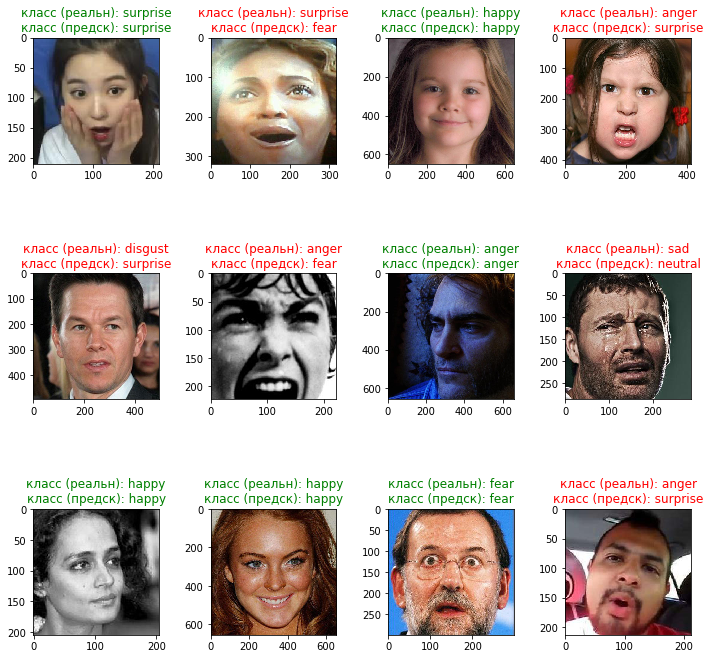

In [60]:
# Тест предсказания

utils.test_model_prediction (p_model = model,
                             p_img_paths = sample_img_paths,
                             p_img_emo_idxs = sample_img_labels,
                             p_img_target_size = (IMAGE_SIZE, IMAGE_SIZE),
                             preprocess_func = preprocess_input,
                             p_emo_classes_names = classes_names)